In [38]:
!pip3 install -e Desktop/Cloud_Orchestration/autoscaling_gym

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/miketz/Desktop/Cloud_Orchestration/autoscaling_gym
  Preparing metadata (setup.py) ... done
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: autoscaling-gym
    Found existing installation: autoscaling-gym 0.0.1
    

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [4]:
import tensorflow as tf
import os
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import parallel_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.system import multiprocessing
from tf_agents.utils import common

2024-03-19 19:33:24.968045: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 19:33:25.020318: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 19:33:25.021838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 19:33:26.125055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
train_dir = os.path.join(os.getcwd(), 'train_dir/')
total_iterations = 700000
num_steps = 1
eval_steps = 120
initial_collect_steps = 1000
initial_collect_checkpoint_interval = 10
# Intervals in train steps
train_checkpoint_interval = 1000
policy_checkpoint_interval = 1000
rb_checkpoint_interval = 1000
eval_interval = 1000
eval_epochs = 3
use_tf_functions = True

In [6]:
learning_rate = 1e-3
gamma = 0.9
epsilon = 0.8
batch_size = 128
replay_buffer_max_length = 100000
target_update_tau = 0.05
target_update_period = 5

In [7]:
try:
    open('test_trans2.csv', 'r').close()
    print('File already present.')
except IOError:
    with open('test_trans2.csv', 'w') as f:
        f.write('current_timestep,arrival_rate,action,reward,'
                'replicas_1,replicas_2,replicas_3,latency,total_reward'
                '\n'
        )
    print('File not present. Created successfully!')

File not present. Created successfully!


In [8]:
global_step = tf.compat.v1.train.get_or_create_global_step()

In [9]:
from autoscaling_gym.envs.AutoScalingEnv import AutoScalingEnv

In [12]:
metrics = 'autoscaling_gym/simulated_metrics.json'
timesteps = 'autoscaling_gym/timesteps.json'

In [13]:
tr_env = AutoScalingEnv(timesteps, metrics)
ev_env = AutoScalingEnv(timesteps, metrics)

train_env = tf_py_environment.TFPyEnvironment(suite_gym.wrap_env(tr_env))
eval_env = tf_py_environment.TFPyEnvironment(suite_gym.wrap_env(ev_env))

In [14]:
print('action_spec:', train_env.action_spec())
print('time_step_spec.observation:', train_env.time_step_spec().observation)
print('time_step_spec.step_type:', train_env.time_step_spec().step_type)
print('time_step_spec.discount:', train_env.time_step_spec().discount)
print('time_step_spec.reward:', train_env.time_step_spec().reward)

action_spec: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(26))
time_step_spec.observation: BoundedTensorSpec(shape=(5,), dtype=tf.float64, name='observation', minimum=array([0., 1., 1., 1., 0.]), maximum=array([1.79769313e+308, 4.00000000e+000, 4.00000000e+000, 4.00000000e+000,
       1.79769313e+308]))
time_step_spec.step_type: TensorSpec(shape=(), dtype=tf.int32, name='step_type')
time_step_spec.discount: BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))
time_step_spec.reward: TensorSpec(shape=(), dtype=tf.float32, name='reward')


In [15]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(100,)
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy=epsilon,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    gamma=gamma
)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

In [16]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length
)
#print(agent.collect_data_spec)

In [17]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=num_steps
)

In [38]:
import shutil

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(os.path.join(train_dir, 'policy')):
    shutil.rmtree(os.path.join(train_dir, 'policy'))
if os.path.exists(os.path.join(train_dir, 'replay_buffer')):
    shutil.rmtree(os.path.join(train_dir, 'replay_buffer'))
train_checkpointer = common.Checkpointer(
    ckpt_dir=train_dir,
    agent=agent,
    global_step=global_step
)

policy_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'policy'),
    policy=eval_policy,
    global_step=global_step
)

rb_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'replay_buffer'),
    max_to_keep=1,
    replay_buffer=replay_buffer
)

train_checkpointer.initialize_or_restore()
rb_checkpointer.initialize_or_restore();

In [39]:
from tf_agents.policies import PolicySaver
my_policy = agent.policy
saver = PolicySaver(my_policy, batch_size=None)
saver.save('agent_policy')

INFO:tensorflow:Assets written to: agent_policy/assets


/home/miketz/.local/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:475: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: agent_policy/assets


In [40]:
initial_collect_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(),
    train_env.action_spec()
)
#print(train_env.time_step_spec())
initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps
)

initial_collect_driver.run = common.function(initial_collect_driver.run)

initial_collect_driver.run();

Reset function is called
Step: 0
Current Workload Rate: 110.0
Current Permutation: 1-1-1
Decoded Action: (1, 1, -1)
Scaled Replicas: [2, 2, 1]
Latency is 0.018
Step: 1
Current Workload Rate: 140.0
Current Permutation: 1-1-1
Decoded Action: (-1, -1, 0)
Scaled Replicas: [1, 1, 1]
Latency is 0.042
Step: 2
Current Workload Rate: 170.0
Current Permutation: 1-1-1
Decoded Action: (0, 1, -1)
Scaled Replicas: [1, 2, 1]
Latency is 4.001
Step: 3
Current Workload Rate: 110.0
Current Permutation: 1-1-2
Decoded Action: (0, 0, -1)
Scaled Replicas: [1, 1, 1]
Latency is 0.025
Step: 4
Current Workload Rate: 140.0
Current Permutation: 1-1-2
Decoded Action: (-1, 0, 0)
Scaled Replicas: [1, 1, 2]
Latency is 0.026
Step: 5
Current Workload Rate: 170.0
Current Permutation: 1-1-2
Decoded Action: (0, 0, 0)
Scaled Replicas: [1, 1, 2]
Latency is 0.129
Step: 6
Current Workload Rate: 110.0
Current Permutation: 1-1-3
Decoded Action: (0, -1, -1)
Scaled Replicas: [1, 1, 2]
Latency is 0.015
Step: 7
Current Workload Rate

In [41]:
 if use_tf_functions:
    # To speed up collect use common.function.
    collect_driver.run = common.function(collect_driver.run)
    agent.train = common.function(agent.train)

time_step = None
policy_state = collect_policy.get_initial_state(train_env.batch_size)

# If num_steps is not set, the dataset returns states and not transitions
# from state to state. So we set it to equal 2 aka a transition from one state to another
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

def train_step():
    experience, _ = next(iterator)
    return agent.train(experience)

if use_tf_functions:
    train_step = common.function(train_step)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [ ]:
global_step.assign(0)
total_reward = 0
while True:
    print('Global step: {}'.format(global_step.numpy()))
    if global_step.numpy() == total_iterations:
        break

    time_step, policy_state = collect_driver.run(
        time_step=time_step,
        policy_state=policy_state
    )
    train_loss = train_step()
    
    if global_step.numpy() % train_checkpoint_interval == 0:
        train_checkpointer.save(global_step=global_step.numpy())

    if global_step.numpy() % policy_checkpoint_interval == 0:
        policy_checkpointer.save(global_step=global_step.numpy())

    if global_step.numpy() % rb_checkpoint_interval == 0:
        rb_checkpointer.save(global_step=global_step.numpy())

    if global_step.numpy() % eval_interval == 0:
        
        eval_time_step = eval_env.reset()
        
        for epoch in range(eval_epochs):
            for step in range(eval_steps):
                action_step = eval_policy.action(eval_time_step)
                #print(action_step)
                eval_time_step = eval_env.step(action_step.action)
                #print(eval_time_step)
                reward = eval_time_step.reward.numpy()[0]
                total_reward += reward
                observation = eval_time_step.observation.numpy()[0]

                (
                 arrival_rate,
                 replicas_1,
                 replicas_2,
                 replicas_3,
                 latency) = observation
                print(observation)
                # Latency violation becomes 1 if the SLA was violated otherwise it's 0
                #latency_violation = int(latency > sla_latency)
                
                #latency_violation_percentage = eval_env.pyenv.envs[0].data['latency_violations']

                # Offset the eval epoch by 1 because the first evaluation takes place at the 10th global step
                current_eval_epoch = (global_step.numpy() // eval_interval) -1
                current_step = (current_eval_epoch * eval_epochs + epoch) * eval_steps + step

                action = action_step.action.numpy()[0]
                print(total_reward)
                # Save historical tuple
                with open('test_trans2.csv', 'a') as f:
                    f.write(
                        '{},{},{},{},'.format(current_step, arrival_rate, action, reward) +
                        '{},{},{},'.format(replicas_1, replicas_2, replicas_3) +
                        '{},{}'.format(latency,total_reward) +
                        '\n'
                    )

        time_step = train_env.reset()

Global step: 0
Step: 40
Current Workload Rate: 75.0
Current Permutation: 1-4-2
Decoded Action: (1, 0, 1)
Scaled Replicas: [2, 4, 3]
Latency is 0.202
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Global step: 1
Step: 41
Current Workload Rate: 80.0
Current Permutation: 1-4-2
Decoded Action: (1, -1, 0)
Scaled Replicas: [2, 3, 2]
Latency is 1.959
Global step: 2
Step: 42
Current Workload Rate: 70.0
Current Permutation: 1-4-3
Decoded Action: (1, -1, 0)
Scaled Replicas: [2, 3, 3]
Latency is 0.124
Global step: 3
Step: 43
Current Workload Rate: 75.0
Current Permutation: 1-4-3
Decoded Action: (0, -1, -1)
Scaled Replicas: [1, 3, 2]
Latency is 0.142
Global step: 4
Step: 44
Current Workload Rate: 80.0
Current Permutation: 1-4-3
Decoded Action: (0, 0, 0)
Scaled Replicas: [1, 4, 3]
Latency is 0.601
Global step: 5
Step: 45
Current Workload Rate: 70.0
Current Permutation: 1-4-4
Decoded Action: (1, 0, -1)
Scaled Replicas: [2, 4, 3]
Latency is 0.08
Global step: 6
Step: 46
Current Workload Rate: 75.0
Current Permutation: 1-4-4
Decoded Action: (0, 1, 0)
Scaled Replicas: [1, 4, 4]
Latency is 0.125
Global step: 7
Step: 47
Current Workload Rate: 80.0
Current Permutation: 1-4-4
Decoded Action: (1, 1, 

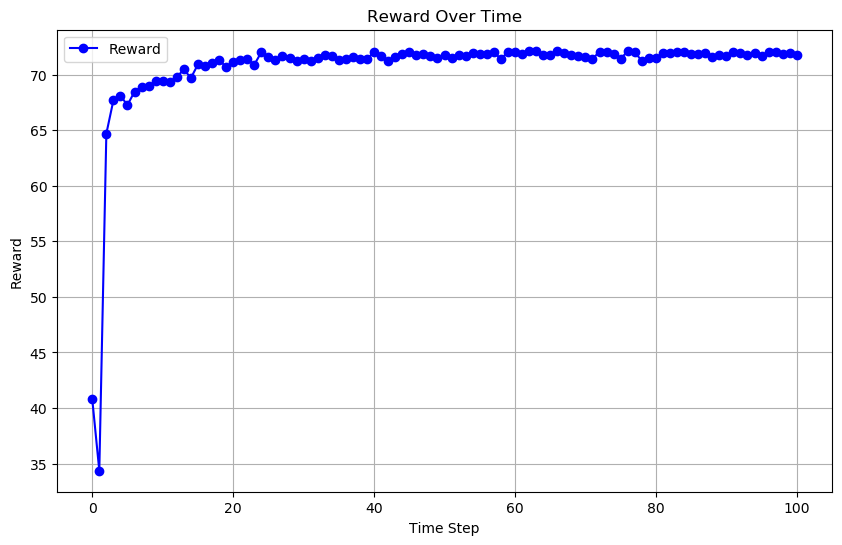

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Read the CSV file into a DataFrame
df = pd.read_csv('test_trans2.csv')

# Assuming the CSV has a column named 'reward' and an index representing time steps
# If the CSV does not have an index, you can create one with:
# df = df.reset_index()
reward = df['reward'].groupby(np.arange(len(df))//2500).mean()
# Plot the 'reward' column
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.plot(reward, marker='o', linestyle='-', color='b', label='Reward')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.title('Reward Over Time')
plt.grid(True)

plt.legend()
#plt.tight_layout()

# Show the plot
plt.show()

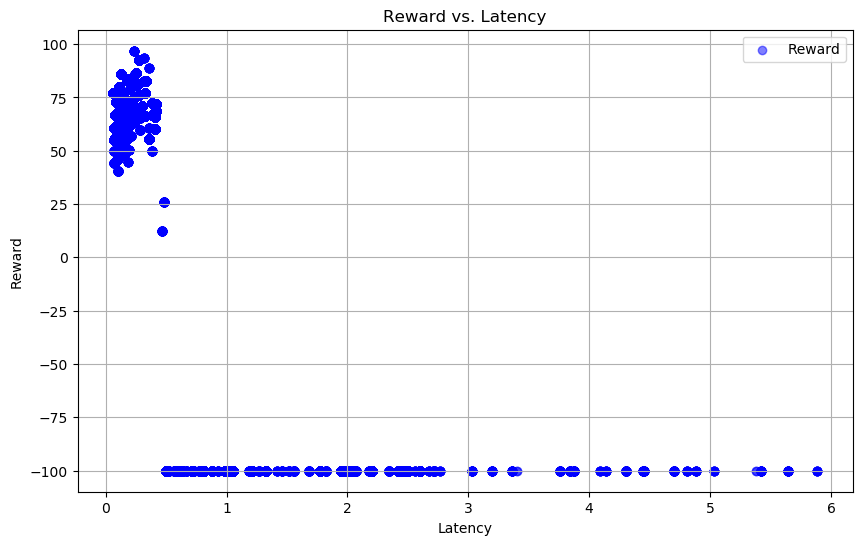

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a DataFrame
data = pd.read_csv('test_trans2.csv')

# Create a new figure with a single subplot
#fig, ax = plt.subplots(figsize=(8, 6))
Latency = np.array(data['latency'])

Reward = np.array(data['reward'])
plt.figure(figsize=(10, 6))
plt.scatter(Latency, Reward, color='b', alpha=0.5, label='Reward')

# Add labels and title
plt.xlabel('Latency')
plt.ylabel('Reward')
plt.title('Reward vs. Latency')
plt.grid(True)
plt.legend()

# Show plot
plt.show()

In [30]:
!pip3 install -e Desktop/Cloud_Orchestration/evaluation_env

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/miketz/Desktop/Cloud_Orchestration/evaluation_env
  Preparing metadata (setup.py) ... done
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: evaluation-env
    Found existing installation: evaluation-env 0.0.1
    Uni

In [17]:
from tf_agents.policies import PolicySaver
my_policy = agent.policy
saver = PolicySaver(my_policy, batch_size=None)
saver.save('agent_policy')

INFO:tensorflow:Assets written to: agent_policy/assets


/home/miketz/.local/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:475: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: agent_policy/assets


In [18]:
eval_policy = tf.saved_model.load('agent_policy')

In [19]:
from evaluation_env.envs.EvaluationEnv import EvaluationEnv
workload_file = 'Desktop/Cloud_Orchestration/evaluation_env/evaluation_env/workload_timesteps.txt'
ev_env = EvaluationEnv(workload_file)
eval_env = tf_py_environment.TFPyEnvironment(suite_gym.wrap_env(ev_env))

print('action_spec:', eval_env.action_spec())
print('time_step_spec.observation:', eval_env.time_step_spec().observation)
print('time_step_spec.step_type:', eval_env.time_step_spec().step_type)
print('time_step_spec.discount:', eval_env.time_step_spec().discount)
print('time_step_spec.reward:', eval_env.time_step_spec().reward)



action_spec: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(26))
time_step_spec.observation: BoundedTensorSpec(shape=(5,), dtype=tf.float64, name='observation', minimum=array([0., 1., 1., 1., 0.]), maximum=array([1.79769313e+308, 4.00000000e+000, 4.00000000e+000, 4.00000000e+000,
       1.79769313e+308]))
time_step_spec.step_type: TensorSpec(shape=(), dtype=tf.int32, name='step_type')
time_step_spec.discount: BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))
time_step_spec.reward: TensorSpec(shape=(), dtype=tf.float32, name='reward')


In [20]:

eval_time_step = eval_env.reset()
action_step = eval_policy.action(eval_time_step)
x=eval_env.step(action_step.action)

print(action_step.action.numpy()[0])

Reset function is called
Step: 0
Waiting for action to take effect...
Current Workload Rate: 70.0
Current Replicas: [2, 2, 2]
Generating workload... 70.0 requests per second
Latency is 12.412
26
